In [57]:
from konlpy.utils import pprint
from konlpy.tag import Kkma
from konlpy.tag import Okt
from konlpy.tag import Twitter
from collections import Counter
import os
import sys
import urllib.request
import ssl
import json
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
plt.rc('font',family='NanumBarunGothic')
#cell magic 명령어 : 그래프를 출력영역에 표시
%matplotlib inline

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\\Windows\\Fonts\\malgun.ttf").get_name()
plt.rc("font", family="Malgun Gothic")

font_path = plt.rc('font', family='Malgun Gothic') 

import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

import seaborn as sns

# (절화)월별전년대비실적 데이터

+ 모든 데이터 통합하기
+ 월별일자 1월~ 12월로 변경 (object)
+ 작년대비(거래량), 작년대비(거래금액) 문장부호 제외하고 int로 (하락은 음수로 표현)
+ 전년(거래량), 금년(거래량) 비율 컬럼 추가

## 데이터 확인

In [2]:
# 데이터 업로드
yj = pd.read_csv("data/월별전년대비실적(양재).csv", encoding= 'cp949')
gj = pd.read_csv('data/월별전년대비실적 (광주풍암).csv', encoding= 'utf8')
bsgd = pd.read_csv('data/월별전년대비실적 (부산강동동).csv', encoding= 'utf8')
bsug = pd.read_csv('data/월별전년대비실적 (부산엄궁동).csv', encoding= 'utf8')

In [3]:
gj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   월별일자        13 non-null     object
 1   전년(거래량)     13 non-null     int64 
 2   금년(거래량)     13 non-null     int64 
 3   작년대비(거래량)   13 non-null     object
 4   전년(거래금액)    13 non-null     int64 
 5   금년(거래금액)    13 non-null     int64 
 6   작년대비(거래금액)  13 non-null     object
dtypes: int64(4), object(3)
memory usage: 856.0+ bytes


## 데이터 통합

In [4]:
del yj["작년대비(거래량)"]
del yj["작년대비(거래금액)"]
del gj["작년대비(거래량)"]
del gj["작년대비(거래금액)"]
del bsgd["작년대비(거래량)"]
del bsgd["작년대비(거래금액)"]
del bsug["작년대비(거래량)"]
del bsug["작년대비(거래금액)"]

In [5]:
df = pd.concat([yj, gj, bsgd, bsug])
result = df.groupby("월별일자").sum()

In [6]:
result["전년대비(거래량)비율"] = result["금년(거래량)"] / result["전년(거래량)"] * 100
result["전년대비(거래금액)비율"] = result["금년(거래금액)"] / result["전년(거래금액)"] * 100

In [7]:
result_2020 = result

## 2020년 코로나 확진자 추이

+ 출처 http://ncov.mohw.go.kr/

### 데이터 전처리

In [8]:
corona = pd.read_csv("data/corona_total.csv", encoding= 'cp949', header = 0, thousands = ',')

In [9]:
corona = corona[["일자", "계(명)"]]
corona.rename(columns = {"계(명)" : "확진자수"}, inplace = True)
corona = corona.drop([corona.index[0]])

In [10]:
import datetime

for i, t in zip(corona["일자"], range(len(corona))):
    corona["일자"][t] = datetime.datetime.strptime(i, "%Y-%m-%d").date()

<ipython-input-10-02e62b04b75d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corona["일자"][t] = datetime.datetime.strptime(i, "%Y-%m-%d").date()


In [11]:
corona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540 entries, 1 to 540
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   일자      540 non-null    object
 1   확진자수    540 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 32.7+ KB


In [12]:
corona = corona[["일자", "확진자수"]]
corona['year'] = pd.DatetimeIndex(corona['일자']).year
corona['month'] = pd.DatetimeIndex(corona['일자']).month

### 2020년과 2021년으로 나누기

**2020년**

In [13]:
corona2020 = corona[corona["year"] == 2020]

In [14]:
corona2020 = corona2020[["month", "확진자수"]]

In [15]:
corona2020 = corona2020.groupby("month").sum()
corona2020.reset_index(inplace = True)
corona2020

,month,확진자수
0,1,7
1,2,2015
2,3,7639
3,4,1100
4,5,680
5,6,1316
6,7,1512
7,8,5429
8,9,4000
9,10,2686


**2021년**

In [16]:
corona2021 = corona[corona["year"] == 2021]

In [17]:
corona2021 = corona2021[["month", "확진자수"]]

In [18]:
corona2021 = corona2021.groupby("month").sum()
corona2021.reset_index(inplace = True)
corona2021

,month,확진자수
0,1,18084
1,2,11466
2,3,13264
3,4,18772
4,5,18562
5,6,16259
6,7,12979


### 시각화 준비

In [108]:
##### 시각화에 필요한 컬럼 따로 생성
result_2020 = result_2020[:-1]
new_corona = result_2020[["전년대비(거래량)비율", "전년대비(거래금액)비율"]]
new_corona.reset_index(inplace = True)
new_corona

,월별일자,전년대비(거래량)비율,전년대비(거래금액)비율
0,2020-01,86.206897,97.723647
1,2020-02,78.754579,69.911185
2,2020-03,74.716981,66.492974
3,2020-04,84.375000,77.120270
4,2020-05,88.921283,81.205729
5,2020-06,103.809524,98.378784
6,2020-07,100.947867,139.547429
7,2020-08,92.670157,104.315361
8,2020-09,75.247525,91.796427
9,2020-10,89.090909,91.842661


In [109]:
test = corona2020["확진자수"].values
test_df = pd.DataFrame({"확진자수" : test})

In [112]:
df = pd.concat([new_corona, test_df], axis = 1)
df2020 = df

In [113]:
##### 데이터를 저장
df2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   월별일자          11 non-null     object 
 1   전년대비(거래량)비율   11 non-null     float64
 2   전년대비(거래금액)비율  11 non-null     float64
 3   확진자수          12 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 512.0+ bytes


### 시각화

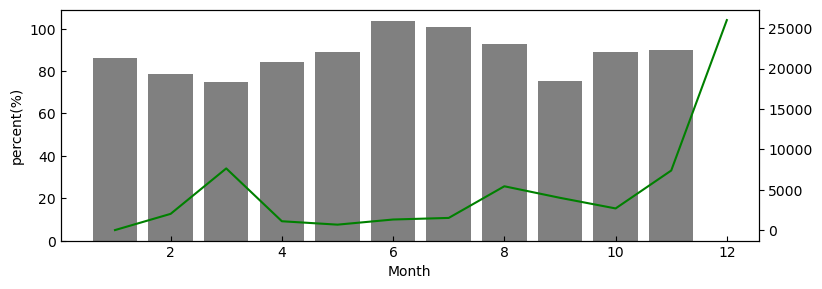

In [138]:
# 1. 기본 스타일 설정
plt.style.use("default")
plt.rcParams['figure.figsize'] = (9, 3)

# 2. 데이터 준비
x = range(1, 13)
y1 = df2020["전년대비(거래량)비율"]
y2 = df2020["확진자수"]

fig, ax1 = plt.subplots()

ax1.bar(x, y1, color='gray', label='전년대비(거래량)비율')
ax1.set_xlabel('Month')
ax1.set_ylabel('percent(%)')
ax1.tick_params(axis='both', direction='in')

ax2 = ax1.twinx()
ax2.plot(x, y2, color = "green", label = "확진자수")

plt.show()

## 2021년 코로나 확진자 추이

### 데이터 전처리

In [120]:
corona2021

,month,확진자수
0,1,18084
1,2,11466
2,3,13264
3,4,18772
4,5,18562
5,6,16259
6,7,12979


In [121]:
# 데이터 업로드

yj2021 = pd.read_excel("data/월별전년대비실적 2021 (양재).xls")
gj2021 = pd.read_excel('data/월별전년대비실적 2021 (광주).xls')
bsgd2021 = pd.read_excel('data/월별전년대비실적 2021 (부산강동동).xls')
bsug2021 = pd.read_excel('data/월별전년대비실적 2021 (부산엄궁동).xls')

In [122]:
yj2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   월별일자        8 non-null      object
 1   전년(거래량)     8 non-null      int64 
 2   금년(거래량)     8 non-null      int64 
 3   작년대비(거래량)   8 non-null      object
 4   전년(거래금액)    8 non-null      int64 
 5   금년(거래금액)    8 non-null      int64 
 6   작년대비(거래금액)  8 non-null      object
dtypes: int64(4), object(3)
memory usage: 576.0+ bytes


In [123]:
yj2021 # 전년대비(거래량)비율 전년대비(거래금액)비율

,월별일자,전년(거래량),금년(거래량),작년대비(거래량),전년(거래금액),금년(거래금액),작년대비(거래금액)
0,2021-01,131,120,8.36% ▼,642228,495158,22.9% ▼
1,2021-02,138,149,8.14% ▲,511212,737436,44.25% ▲
2,2021-03,158,213,35.05% ▲,425838,838103,96.81% ▲
3,2021-04,179,204,13.94% ▲,496727,801192,61.29% ▲
4,2021-05,206,202,2.25% ▼,763367,1044790,36.87% ▲
5,2021-06,145,159,9.25% ▲,427365,604214,41.38% ▲
6,2021-07,120,113,5.54% ▼,414218,368514,11.03% ▼
7,합계,1081,1164,7.67% ▲,3680958,4889410,32.83% ▲


In [124]:
del yj2021["작년대비(거래량)"]
del yj2021["작년대비(거래금액)"]
del gj2021["작년대비(거래량)"]
del gj2021["작년대비(거래금액)"]
del bsgd2021["작년대비(거래량)"]
del bsgd2021["작년대비(거래금액)"]
del bsug2021["작년대비(거래량)"]
del bsug2021["작년대비(거래금액)"]

In [125]:
yj2021

,월별일자,전년(거래량),금년(거래량),전년(거래금액),금년(거래금액)
0,2021-01,131,120,642228,495158
1,2021-02,138,149,511212,737436
2,2021-03,158,213,425838,838103
3,2021-04,179,204,496727,801192
4,2021-05,206,202,763367,1044790
5,2021-06,145,159,427365,604214
6,2021-07,120,113,414218,368514
7,합계,1081,1164,3680958,4889410


In [126]:
df = pd.concat([yj2021, gj2021, bsgd2021, bsug2021])
result = df.groupby("월별일자").sum()

In [127]:
result["전년대비(거래량)비율"] = result["금년(거래량)"] / result["전년(거래량)"] * 100
result["전년대비(거래금액)비율"] = result["금년(거래금액)"] / result["전년(거래금액)"] * 100

In [128]:
result_2021 = result

In [129]:
result_2021

,전년(거래량),금년(거래량),전년(거래금액),금년(거래금액),전년대비(거래량)비율,전년대비(거래금액)비율
월별일자,,,,,,
2021-01,207,181,969674,731003,87.439614,75.386470
2021-02,224,225,789529,1064823,100.446429,134.868130
2021-03,205,304,548035,1199265,148.292683,218.830002
2021-04,250,288,694343,1138351,115.200000,163.946493
2021-05,312,289,1113752,1447939,92.628205,130.005513
2021-06,224,222,660342,839930,99.107143,127.196210
2021-07,173,161,587992,528435,93.063584,89.871121
합계,1608,1684,5363678,6949758,104.726368,129.570754


### 시각화 준비

In [130]:
result_2021 = result_2021[:-1]
new_corona = result_2021[["전년대비(거래량)비율", "전년대비(거래금액)비율"]]
new_corona.reset_index(inplace = True)
new_corona

,월별일자,전년대비(거래량)비율,전년대비(거래금액)비율
0,2021-01,87.439614,75.386470
1,2021-02,100.446429,134.868130
2,2021-03,148.292683,218.830002
3,2021-04,115.200000,163.946493
4,2021-05,92.628205,130.005513
5,2021-06,99.107143,127.196210
6,2021-07,93.063584,89.871121


In [131]:
test = corona2021["확진자수"].values
test_df = pd.DataFrame({"확진자수" : test})

In [132]:
df = pd.concat([new_corona, test_df], axis = 1)
df2021 = df

In [133]:
df2021

,월별일자,전년대비(거래량)비율,전년대비(거래금액)비율,확진자수
0,2021-01,87.439614,75.386470,18084
1,2021-02,100.446429,134.868130,11466
2,2021-03,148.292683,218.830002,13264
3,2021-04,115.200000,163.946493,18772
4,2021-05,92.628205,130.005513,18562
5,2021-06,99.107143,127.196210,16259
6,2021-07,93.063584,89.871121,12979


### 시각화

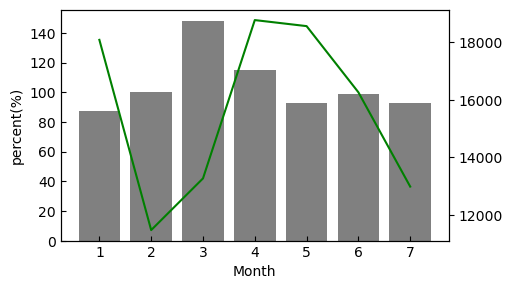

In [137]:
# 1. 기본 스타일 설정
plt.style.use("default")
plt.rcParams['figure.figsize'] = (5, 3)

# 2. 데이터 준비
x = range(1, 8)
y1 = df2021["전년대비(거래량)비율"]
y2 = df2021["확진자수"]

fig, ax1 = plt.subplots()

ax1.bar(x, y1, color='gray', label='전년대비(거래량)비율')
ax1.set_xlabel('Month')
ax1.set_ylabel('percent(%)')
ax1.tick_params(axis='both', direction='in')

ax2 = ax1.twinx()
ax2.plot(x, y2, color = "green", label = "확진자수")

plt.show()